In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

import lifelines

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.lines as mlines

# Autoencoding colorectal cancer

First, load the mRNA data

In [2]:
DATADIR = "/data/local/jona/compcancer-2020/data/"

In [3]:
mrna = pd.read_csv(os.path.join(DATADIR, "crc-mrna.csv.gz"), index_col=0)
mrna.head()

,TCGA-DM-A1D0,TCGA-4T-AA8H,TCGA-G4-6322,TCGA-AA-A02E,TCGA-CA-5797,TCGA-G4-6317,TCGA-DM-A28C,TCGA-A6-2679,TCGA-AG-3732,TCGA-A6-2685,...,TCGA-CK-5912,TCGA-CI-6624,TCGA-G5-6235,TCGA-F4-6808,TCGA-QL-A97D,TCGA-NH-A6GB,TCGA-AG-3893,TCGA-G4-6586,TCGA-AA-A02H,TCGA-AD-6890
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000202198,4.855891,9.205568,6.527440,0.595815,6.004349,45.198805,5.171670,9.297939,2.890794,15.342999,...,8.135898,5.957633,2.692273,4.692869,5.968598,12.310332,12.627120,7.663521,5.460828,14.890009
ENSG00000211895,0.831433,662.091659,2253.907738,227.896559,259.448507,33.497148,92.531871,26781.944993,2012.832725,1666.767573,...,267.495095,2270.226845,98.756955,27.513710,1805.132552,848.237678,132.075879,116.733943,430.481361,1156.593678
ENSG00000034510,3005.830071,2393.902606,2312.832191,2896.691270,2658.153543,3291.309014,2007.805579,5385.831438,1299.339179,3863.095508,...,1694.241437,1938.263787,1796.824817,3139.115329,2053.738952,1386.395260,1965.545436,5009.091625,2922.969666,4880.246019
ENSG00000087086,13913.949581,1139.065773,1780.765946,2380.278895,3286.305387,2322.741438,2210.857310,1576.866087,1134.467501,3661.551885,...,1379.410102,1783.817894,2337.802567,5144.142661,2633.504427,2440.106135,3077.890496,2828.328678,2688.483909,2722.514303
ENSG00000102837,46.555391,73.775732,499.938588,339.271345,146.964388,38.123727,3593.373932,190.109445,121.231444,108.279930,...,8.145296,139.563538,221.134839,5345.460417,7.747256,32.518598,111.224092,6.027920,750.955431,454.319946


Observe the skewed distributions of the features (genes). These will need to be normalized in some way to get them to work with neural networks.

(-1, 1000)

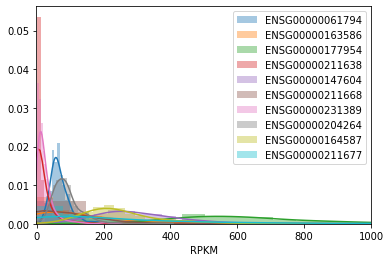

In [5]:
fig,ax = plt.subplots()
for gene in np.random.choice(mrna.index, 10, replace=False):
    sns.distplot(mrna.loc[gene], ax=ax, label=gene)
plt.legend()
ax.set_xlabel("RPKM")
ax.set_xlim(-1,1000)

Normally, we'll log-transform RPKM values to get them to look more normal

Text(0.5, 0, 'log(RPKM+1)')

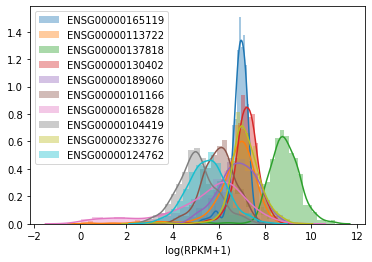

In [7]:
mrna_log = np.log2(mrna+1)

fig,ax = plt.subplots()
for gene in np.random.choice(mrna.index, 10, replace=False):
    sns.distplot(mrna_log.loc[gene], ax=ax, label=gene)
plt.legend()
ax.set_xlabel("log(RPKM+1)")
# ax.set_xlim(-1,1000)

Next, we'll scale these so they all are closer to 0

Text(0.5, 0, 'scaled RPKM')

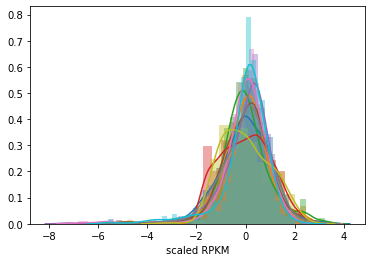

In [8]:
mrna_scaled = pd.DataFrame(
    scale(mrna_log.copy(), axis=1),
    index=mrna.index,
    columns=mrna.columns
)

fig,ax = plt.subplots()
for gene in np.random.choice(mrna.index, 10, replace=False):
    sns.distplot(mrna_scaled.loc[gene], ax=ax, label=gene)
plt.legend
ax.set_xlabel("scaled RPKM")

Next, load the subtype data

In [9]:
subtypes = pd.read_csv(os.path.join(DATADIR, "crc-subtypes.csv.gz"), index_col=0)
subtypes.head()

,dataset,age,gender,stage,pt,pn,pm,tnm,grade,msi,cimp,kras_mut,braf_mut,cms_label,osMo,osStat,rfsMo,rfsStat
sample,,,,,,,,,,,,,,,,,,
TCGA-A6-2670,tcga,45.0,male,2.0,3.0,0.0,0.0,IIA,NaN,NaN,CIMP.Neg,0.0,0.0,CMS4,13.906849,0.0,NaN,NaN
TCGA-A6-2671,tcga,85.0,male,4.0,3.0,2.0,1.0,IV,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,21.304110,0.0,NaN,NaN
TCGA-A6-2672,tcga,82.0,female,3.0,3.0,1.0,0.0,IIIB,NaN,msi,CIMP.High,0.0,0.0,CMS1,16.536986,0.0,NaN,NaN
TCGA-A6-2674,tcga,71.0,male,4.0,3.0,2.0,1.0,IV,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,17.194521,0.0,NaN,NaN
TCGA-A6-2675,tcga,78.0,male,2.0,3.0,0.0,NaN,IIA,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,16.931507,0.0,NaN,NaN


Just to get a rough idea of what this data looks like, let's make a scatter plot

In [11]:
sample2subtype = dict(zip(subtypes.index, subtypes.cms_label))
subtype2color = dict(zip(sorted(subtypes.cms_label.unique()), sns.color_palette()))

sample_colors = [subtype2color.get(sample2subtype.get(s, "NOLBL")) for s in mrna.columns]

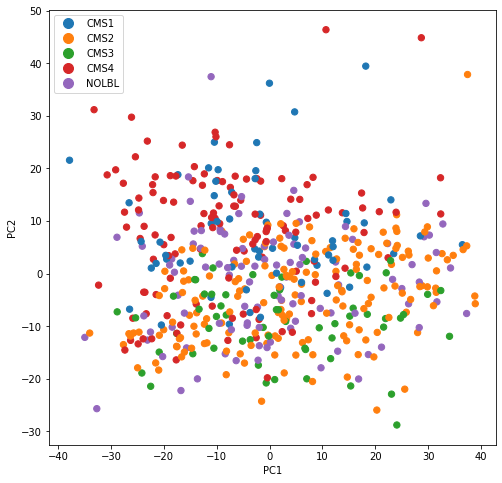

In [12]:
fig,ax = plt.subplots(figsize=(8,8))

pd.DataFrame(
    PCA(2).fit_transform(mrna_log.T),
    index=mrna_scaled.columns,
    columns=["PC1", "PC2"]
).plot.scatter("PC1", "PC2", color=sample_colors, s=40, ax=ax)

cms_legend_handles = [mlines.Line2D([],[], label=label, color=color, markersize=10, marker="o", linewidth=0) for label, color in subtype2color.items()]
ax.legend(handles=cms_legend_handles)

For another quick look at the data, let's explore these subtypes' survival rates. First, load the survival data.

In [13]:
survival = pd.read_csv(os.path.join(DATADIR, "crc-survival.csv.gz"), index_col=0)
survival.head()

,duration,observed,gender,age,stage
bcr_patient_barcode,,,,,
TCGA-3L-AA1B,154,False,0,61.312329,1.0
TCGA-4N-A93T,8,False,1,67.186301,3.0
TCGA-4T-AA8H,160,False,0,42.449315,2.0
TCGA-5M-AAT4,49,True,1,74.232877,4.0
TCGA-5M-AAT6,290,True,0,40.690411,4.0


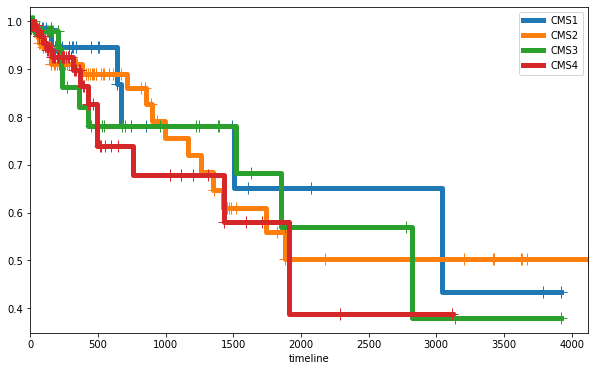

In [14]:
fig,ax = plt.subplots(figsize=(10,6))

kmf = lifelines.KaplanMeierFitter()
for subtype in [f"CMS{i}" for i in range(1,5)]:
    patients = subtypes[subtypes.cms_label==subtype].index
    patients_with_survival = set(patients) & set(survival.index)
    s = survival.loc[patients_with_survival]
    kmf.fit(s.duration, s.observed, label=subtype)
    kmf.plot(ax=ax, ci_show=False, show_censors=True, linewidth=5)

----------------

# Fitting an autoencoder

In [15]:
import tensorflow as tf
from tensorflow import keras

tf.keras.backend.clear_session()
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

tf.version.VERSION

'2.0.0'

First, define a model:

In [16]:
input_size = mrna.shape[0]
embedding_size = 2

mrna_input = keras.layers.Input(shape=(input_size,), name="input")
hidden = keras.layers.Dense(embedding_size, activation="sigmoid", name="hidden")(mrna_input)
output = keras.layers.Dense(input_size, activation="sigmoid", name="reconstruction")(hidden)
ae = tf.keras.Model(mrna_input, output, name="Vanilla autoencoder")

ae.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mean_squared_error)

In [17]:
ae.summary()

Model: "Vanilla autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1000)]            0         
_________________________________________________________________
hidden (Dense)               (None, 2)                 2002      
_________________________________________________________________
reconstruction (Dense)       (None, 1000)              3000      
Total params: 5,002
Trainable params: 5,002
Non-trainable params: 0
_________________________________________________________________


In [18]:
x_train, x_test = train_test_split(mrna_scaled.T, train_size=.9)

In [19]:
ae.fit(x=x_train, y=x_train, validation_data=[x_test, x_test], epochs=500)

Train on 467 samples, validate on 52 samples
Epoch 1/500
467/467 [==============================] - 0s 203us/sample - loss: 1.2503 - val_loss: 1.1459
Epoch 2/500
467/467 [==============================] - 0s 47us/sample - loss: 1.2422 - val_loss: 1.1381
Epoch 3/500
467/467 [==============================] - 0s 46us/sample - loss: 1.2334 - val_loss: 1.1300
Epoch 4/500
467/467 [==============================] - 0s 45us/sample - loss: 1.2243 - val_loss: 1.1221
Epoch 5/500
467/467 [==============================] - 0s 46us/sample - loss: 1.2156 - val_loss: 1.1142
Epoch 6/500
467/467 [==============================] - 0s 45us/sample - loss: 1.2069 - val_loss: 1.1067
Epoch 7/500
467/467 [==============================] - 0s 45us/sample - loss: 1.1985 - val_loss: 1.0997
Epoch 8/500
467/467 [==============================] - 0s 45us/sample - loss: 1.1906 - val_loss: 1.0929
Epoch 9/500
467/467 [==============================] - 0s 44us/sample - loss: 1.1828 - val_loss: 1.0863
Epoch 10/500
467/4

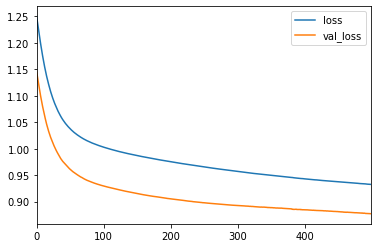

In [20]:
pd.DataFrame(ae.history.history).plot()

Now since we're satisfied with the overall performance of this autoencoder, let's split it up in encoder and decoder. After all, it's mainly the encoder we're interested in, in order to perform dimensionality reduction...

In [21]:
encoder = keras.Model(mrna_input, hidden, name="Encoder")
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1000)]            0         
_________________________________________________________________
hidden (Dense)               (None, 2)                 2002      
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________


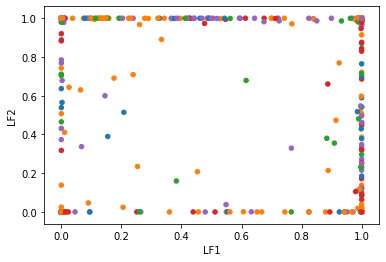

In [22]:
z = pd.DataFrame(
    encoder.predict(mrna_scaled.T),
    index=mrna_scaled.columns,
    columns=[f"LF{i}" for i in range(1, embedding_size+1)]
)
z.plot.scatter("LF1", "LF2", color=sample_colors)

Not super impressive. How about using a larger network?

In [45]:
input_size = mrna.shape[0]
embedding_size = 100

def make_vanilla_autoencoder(input_size, embedding_size):
    mrna_input = keras.layers.Input(shape=(input_size,), name="input")
    hidden = keras.layers.Dense(embedding_size, activation="sigmoid", name="hidden")(mrna_input)
    output = keras.layers.Dense(input_size, activation="sigmoid", name="reconstruction")(hidden)
    ae = tf.keras.Model(mrna_input, output, name="Vanilla autoencoder")

    ae.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mean_squared_error)
    
    encoder = keras.Model(mrna_input, hidden, name="Encoder")
    return ae, encoder

ae, encoder = make_vanilla_autoencoder(input_size, embedding_size)

In [46]:
ae.summary()

Model: "Vanilla autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1000)]            0         
_________________________________________________________________
hidden (Dense)               (None, 100)               100100    
_________________________________________________________________
reconstruction (Dense)       (None, 1000)              101000    
Total params: 201,100
Trainable params: 201,100
Non-trainable params: 0
_________________________________________________________________


In [47]:
ae.fit(x=x_train, y=x_train, validation_data=[x_test, x_test], epochs=1000)

Train on 467 samples, validate on 52 samples
Epoch 1/1000
467/467 [==============================] - 0s 228us/sample - loss: 1.1816 - val_loss: 1.0097
Epoch 2/1000
467/467 [==============================] - 0s 68us/sample - loss: 1.0566 - val_loss: 0.9445
Epoch 3/1000
467/467 [==============================] - 0s 66us/sample - loss: 1.0046 - val_loss: 0.9187
Epoch 4/1000
467/467 [==============================] - 0s 66us/sample - loss: 0.9833 - val_loss: 0.9037
Epoch 5/1000
467/467 [==============================] - 0s 65us/sample - loss: 0.9705 - val_loss: 0.8926
Epoch 6/1000
467/467 [==============================] - 0s 65us/sample - loss: 0.9599 - val_loss: 0.8820
Epoch 7/1000
467/467 [==============================] - 0s 66us/sample - loss: 0.9495 - val_loss: 0.8716
Epoch 8/1000
467/467 [==============================] - 0s 66us/sample - loss: 0.9398 - val_loss: 0.8613
Epoch 9/1000
467/467 [==============================] - 0s 67us/sample - loss: 0.9299 - val_loss: 0.8519
Epoch 10/

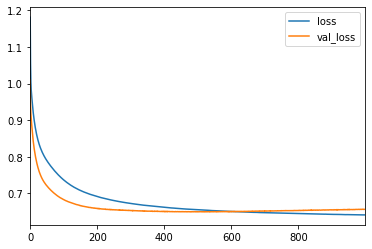

In [48]:
pd.DataFrame(ae.history.history).plot()

Here, it looks like the validation loss is actually increasing, though the training loss is decreasing, after approximately epoch 400:

(0.575, 0.7)

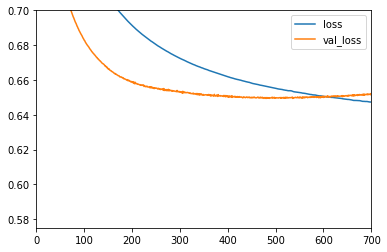

In [49]:
pd.DataFrame(ae.history.history).plot()
plt.xlim(0,700)
plt.ylim(.575,.7)

A good way to deal with this is by early stopping. In tensorflow 2.0 / keras, we have this easy-to-use callback:

In [50]:
ae, encoder = make_vanilla_autoencoder(input_size, embedding_size)
ae.fit(
    x=x_train,
    y=x_train,
    validation_data=[x_test, x_test],
    epochs=1000,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3
    )]
)

Train on 467 samples, validate on 52 samples
Epoch 1/1000
467/467 [==============================] - 0s 224us/sample - loss: 1.1752 - val_loss: 1.0100
Epoch 2/1000
467/467 [==============================] - 0s 77us/sample - loss: 1.0546 - val_loss: 0.9421
Epoch 3/1000
467/467 [==============================] - 0s 75us/sample - loss: 1.0029 - val_loss: 0.9163
Epoch 4/1000
467/467 [==============================] - 0s 76us/sample - loss: 0.9821 - val_loss: 0.9014
Epoch 5/1000
467/467 [==============================] - 0s 77us/sample - loss: 0.9694 - val_loss: 0.8900
Epoch 6/1000
467/467 [==============================] - 0s 75us/sample - loss: 0.9585 - val_loss: 0.8791
Epoch 7/1000
467/467 [==============================] - 0s 76us/sample - loss: 0.9478 - val_loss: 0.8681
Epoch 8/1000
467/467 [==============================] - 0s 74us/sample - loss: 0.9374 - val_loss: 0.8578
Epoch 9/1000
467/467 [==============================] - 0s 74us/sample - loss: 0.9275 - val_loss: 0.8483
Epoch 10/

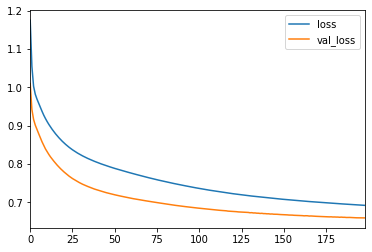

In [51]:
pd.DataFrame(ae.history.history).plot()

Here, the model stopped training after the validation loss leveled off. Now, let's use it, by using the encoder network:

In [52]:
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1000)]            0         
_________________________________________________________________
hidden (Dense)               (None, 100)               100100    
Total params: 100,100
Trainable params: 100,100
Non-trainable params: 0
_________________________________________________________________


In [53]:
z = pd.DataFrame(
    encoder.predict(mrna_scaled.T),
    index=mrna_scaled.columns,
    columns=[f"LF{i}" for i in range(1, embedding_size+1)]
)
z.head()

,LF1,LF2,LF3,LF4,LF5,LF6,LF7,LF8,LF9,LF10,...,LF91,LF92,LF93,LF94,LF95,LF96,LF97,LF98,LF99,LF100
TCGA-DM-A1D0,0.994035,0.000010,0.997491,0.000181,0.304901,0.000015,0.992612,0.124776,0.791235,1.000000,...,0.992061,0.004241,0.000107,0.999779,0.999794,1.000000,2.972204e-01,0.999586,0.999416,0.999999
TCGA-4T-AA8H,0.999985,0.000032,0.997031,0.992992,0.999999,0.024542,0.999971,0.000000,0.999642,0.999699,...,1.000000,0.999943,0.001447,0.999999,0.008716,0.999990,9.991350e-01,0.995475,0.999994,0.994036
TCGA-G4-6322,0.000006,1.000000,0.999769,0.000227,0.996771,0.998674,0.999275,0.820989,0.000150,0.005045,...,0.042272,0.004456,0.999903,0.998620,0.999331,0.002665,9.999962e-01,0.000932,0.437283,0.950393
TCGA-AA-A02E,0.010100,0.994817,0.997638,0.014696,0.000007,0.004536,0.998899,0.115798,0.999184,0.000127,...,0.999985,0.999929,0.002395,0.000429,0.995392,0.000487,1.490116e-07,0.001095,0.026704,0.998891
TCGA-CA-5797,0.999314,0.005033,0.964617,0.000325,0.999974,0.999925,0.878162,1.000000,0.783658,0.976081,...,0.000211,0.001008,0.978964,0.008509,0.000202,0.644507,1.698315e-03,0.001117,0.998429,0.571884


Now, as `z` has 100 latent factors in it, let's plot a PCA of those, in order to get a 2D visualization:

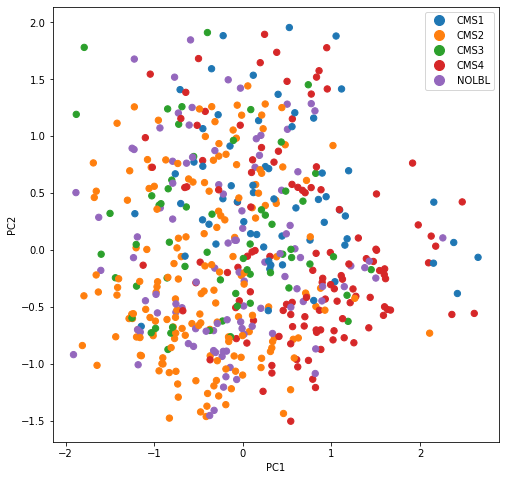

In [147]:
fig,ax = plt.subplots(figsize=(8,8))

pd.DataFrame(PCA(2).fit_transform(z), columns=["PC1", "PC2"], index=z.index).plot.scatter("PC1", "PC2", color=sample_colors, s=40, ax=ax)

ax.legend(handles=cms_legend_handles)

So, using a simple autoencoder, we've reduced the dimensionality from 1,000 genes to 100 latent factors. Then, we used PCA to get 2 dimensions, which we plot here. Whether or not these are better than PCA on the original data is left as an exercise.

However, we could also use this reduced dimension latent space to define our own clusters, i.e. CRC subtypes. For instance, using k-means:

In [54]:
ae_clusters = pd.Series(KMeans(4).fit_predict(z), index=z.index)

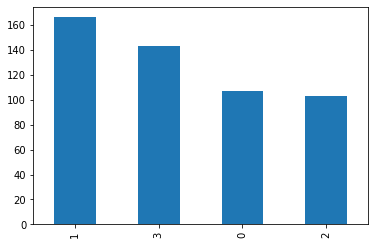

In [55]:
ae_clusters.value_counts().plot.bar()

In [57]:
sample2cluster = dict(zip(ae_clusters.index, ae_clusters))
cluster2color = dict(zip(sorted(ae_clusters.unique()), sns.color_palette()))

sample_colors_ae_clusters = [cluster2color.get(sample2cluster.get(s)) for s in ae_clusters.index]

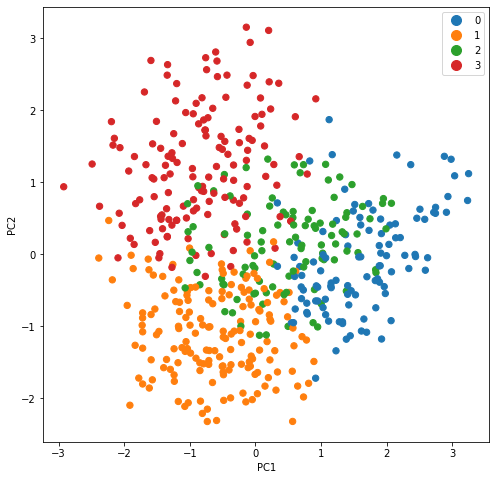

In [58]:
fig,ax = plt.subplots(figsize=(8,8))

pd.DataFrame(PCA(2).fit_transform(z), columns=["PC1", "PC2"], index=z.index).plot.scatter("PC1", "PC2", color=sample_colors_ae_clusters, s=40, ax=ax)

ae_clusters_legend_handles = [mlines.Line2D([],[], label=label, color=color, markersize=10, marker="o", linewidth=0) for label, color in cluster2color.items()]
ax.legend(handles=ae_clusters_legend_handles)

So using k-means, we've split the patients into four groupings. Do these groupings reveal anything interesting? Let's for instance examine their survival statistics:

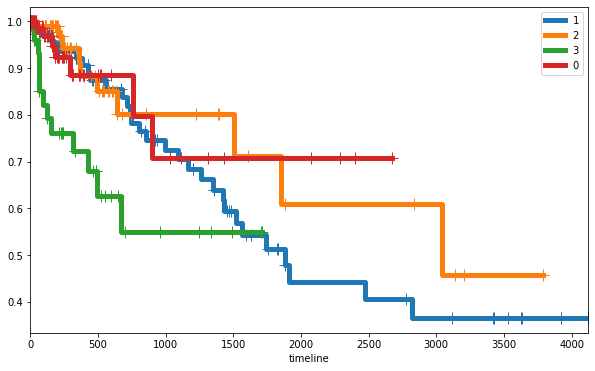

In [59]:
fig,ax = plt.subplots(figsize=(10,6))

kmf = lifelines.KaplanMeierFitter()
for cl in ae_clusters.unique():
    patients = ae_clusters[ae_clusters==cl].index
    patients_with_survival = set(patients) & set(survival.index)
    s = survival.loc[patients_with_survival]
    kmf.fit(s.duration, s.observed, label=cl)
    kmf.plot(ax=ax, ci_show=False, show_censors=True, linewidth=5)

---------------------

# Exercises

## Regularization

### Exercise 1 (EASY): add l1 regularization to the autoencoder

A vanilla autoencoder like this is probably going to produce a fairly dense network, i.e. one where most nodes are connected with most nodes. We can examine the weights of the network like this:

Text(0.5, 0, '$\\|w\\|$')

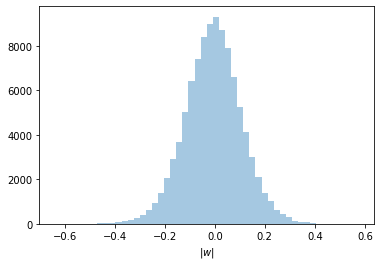

In [60]:
sns.distplot(ae.layers[1].get_weights()[0].flatten(), kde=False)
plt.xlabel(r"$\|w\|$")

This distribution of weights is approximately normal.

Hint: `keras.layers.Dense?`, or https://keras.io/regularizers/

In [ ]:
# your code here

### Exercise 2 (EASY): De-noising autoencoder (DAE)

Recall that a denoising autoencoder adds noise to the input **but not to the output** so that it learns to reconstruct a noise-free sample from noisy input. The DAE learns not only to reconstruct noise free samples, but because all noise applied to an input should result in the same output, it also results in the same latent space representation. Hence, the DAE learns that samples which are _within noise_ of each other, should have the same latent representations. This feature makes DAEs learn smooth manifolds, a great advantage over vanilla AEs.

A naive way to implement a DAE is simply to add noise to `x` for the input, and train it using `model.fit(x+noise, x)`. This approach, however, misses out on the manifold-building advantages of DAEs, as each sample only gets one characteristic "noise" attached to it, no matter how many epochs we train it for.

**Implement a DAE which does not have this drawback**.

Hint: `keras.layers.GaussianNoise?`

In [ ]:
# your code here

### Exercise 3 (CHALLENGING): Variational Autoencoder (VAE)

Recall that a variational autoencoder learns **distributions** for latent factors, rather than a deterministic mapping, i.e. $z \sim q(z|x,w)$. Setting it as a normally distributed variable, this means learning a **mean** and **standard deviation** for each latent factor, rather than a simple value. Using the reparametrization trick, this is achieved by having two parallel layers representing the mean and std, followed by a sampling procedure to get `z`s.

Finally, the KL-divergence of $q(z|x,w)$ from a unit gaussian needs to be added to the loss function.

**Implement a VAE**.

_Tip:_ Typically when implementing VAEs, a network is taught to estimate $\mu$ and $log(\sigma)$. This results in more stable estimates.

_Hint:_ the KL divergence of a normally distributed $q(z|x,w)$ from a unit normal is given by:

$$
KL(\mathcal{N}(\mu, \Sigma)||\mathcal{N}(0,1)) = \frac{1}{2} \sum_k \left( \sigma_k + \mu_k^2 - log(\sigma_k) - 1 \right)
$$

This term will need to be added to the model's **loss**, in addition to the reconstruction loss, to complete the ELBO. Hint: `model.add_loss?`.

_Another hint:_ Sampling from a distribution (using the reparametrization trick) can be achieved using a custom function layer. This layer can take the $\mu$ and $\sigma$ as inputs, and sample from a distribution given by these parameters. Hint: `keras.layers.Lambda?` and `tf.random.normal?`.

In [ ]:
# your code here

### Exercise 4 (EXTRA CHALLENGING): Contractive autoencoder (CAE)

The CAE aims to give close latent representations to points which are close in input space. This is achieved by penalizing the frobenius norm of the jacobian of hidden neuron activations with respect to inputs, i.e. the gradient of the hidden layer with respect to the input. For an intuition behind this, we don't want small perturbations in the input to result in large perturbations in the latent space. The gradient of the hidden with respect to the input represents the size of latent space perturbations resulting from input perturbations. With a tuning parameter $\lambda$, this results in a loss function $\mathcal{L} = MSE + \lambda\|J_x(z)\|_F$.

**Implement a contractive autoencoder**.

_Hint:_ Take a look at the TensorFlow subclassing API. Specifically, how to add losses: https://www.tensorflow.org/guide/keras/custom_layers_and_models#layers_recursively_collect_losses_created_during_the_forward_pass.

In [64]:
# your code here

-------------

## Deep autoencoders

### Exercise 5 (EASY): Deep Vanilla Autoencoder (Stacked AEs)

**Implement an n-layer vanilla autoencoder**.

**Question: Is there a disadvantage to stacking AEs?**

In [ ]:
# your code here

### Exercise 6 (CHALLENGING): Stacked Variational Autoencoders

**Implement stacked VAEs**.

**Variant 1: several "regular" layers with one "variational" layer in the middle**

**Variant 2: variational at each layer**

In [ ]:
# your code here

--------------

## Model Interpretation

### Exercise 7 (EASY): Explain which genes are associated with each latent factor

Using the weights from input genes to hidden neurons, we can explain which genes are behind each latent factor.

**Question 1:** are l1-regularized autoencoders sparser than "vanilla" autoencoders? Can a relationship be established between the regularization parameter and the number of genes associated with each latent factor?

**Question 2:** Are DAEs, VAEs, or CAEs better at creating sparser autoencoders?

In [ ]:
# your code bere

### Exercise 8 (SLIGHTLY CHALLENGING): Explaining deep autoencoders

**Question**: How would you establish the connection between input genes and latent factors in a deep autoencoder?

In [ ]:
# your code here

### Exercise 9 (SLIGHTLY CHALLENGING): pruning over-parameterized autoencoders

We've seen the advantages of over-parameterizing autoencoders, e.g. by specifying a larger hidden dimension than we think is really latent in the data. The challenge remains to decide how to prune the "noise" latent factors in our model.

1. Implement model pruning by _proportion of variance explained_, i.e. only keep those latent factors which explain a significant amount of variance in the input data.
    1. (extra points) can this be done while training?
2. Implement model pruning by gene set enrichment, i.e. associate each latent factor with genes, and only keep the ones which are associated with interesting gene sets
3. Implement model pruning by clinical relevance, i.e. only keep latent factors which are predictive of patient survival
4. Can you think of any other ways to subspace the large latent space we've inferred?

In [ ]:
# your code here

## Combining models

### Exercise 10 (CHALLENGING): Using a pre-trained autoencoder as a component in another neural network

A major advantage of autoencoders being unsupervised learning techniques is, they do not require any labels, and can be used to learn patterns in data which is unlabeled. However, sometimes we want to train models to perform supervised learning tasks, e.g. classifying patients into a CMS subtype based on their molecular profiles.

We have molecular profiles for more patients than we have subtype labels for:

In [68]:
mrna_patients = set(mrna.columns)
subt_patients = set(subtypes[subtypes.cms_label.isin({f"CMS{i}" for i in range(1,5)})].index)
print(f"Out of {len(mrna_patients)} patients with mRNA seq, we have CMS labels for {len(mrna_patients & subt_patients)}.")

Out of 519 patients with mRNA seq, we have CMS labels for 419.


It would be a shame to throw away the molecular profile of the 100 patients (representing 20% of the data at hand!), if we wanted to train a classifier to predict the CMS subtype from the mRNA profile.

One way to make use of the data, is to **pre-train** an autoencoder on all of the data (both labeled and unlabeled). The resulting encoder network will have learned to create a meaningful representation of the input, and it will have made use of the unlabeled samples too in doing so. Then in the next step, we can use this pre-trained encoder network, put another dense/softmax layer at the end, and teach that thing to classify tumors into their CMS subtypes based on their mRNA profiles.

In [ ]:
# your code here

### Exercise 11 (MODERATE): Multi-omics autoencoder

We've also made available mutation and copy number data for the colorectal tumors:

In [ ]:
muts = pd.read_csv(os.path.join(DATADIR, "crc-muts.csv.gz"), index_col=0)
cnvs = pd.read_csv(os.path.join(DATADIR, "crc-cnvs.csv.gz"), index_col=0)

**Implement a multi-omics integration autoencoder**

In [ ]:
# your code here